In [2]:
import pandas as pd
import numpy as np
import openpyxl as xl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima

importation de donnees

In [49]:
df=pd.read_excel("FS_DATA_DAS.xlsx")
df

,Date,Recettes,Change,IPC
0,1998-10-01,4.511900e+08,16.3043,7.497835
1,1998-11-01,3.793800e+08,16.5948,8.022774
2,1998-12-01,3.967000e+08,16.5046,7.447713
3,1999-01-01,4.376500e+08,16.7778,7.375875
4,1999-02-01,4.147200e+08,16.8943,7.932369
...,...,...,...,...
315,2025-01-01,6.651080e+09,130.1714,29.700000
316,2025-02-01,8.543862e+09,130.5536,28.400000
317,2025-03-01,4.137746e+09,130.5296,25.200000
318,2025-04-01,5.062340e+09,130.5819,26.800000


differenciation premiere de toutes les series

In [50]:
# Différenciation simple (1re différence)
df['dRecettes'] = df['Recettes'] - df['Recettes'].shift(1)
df['dIPC'] = df['IPC'] - df['IPC'].shift(1)
df['dChange'] = df['Change'] - df['Change'].shift(1)


# Supprimer la première ligne (valeurs manquantes)
df_model = df.dropna()

df_model

,Date,Recettes,Change,IPC,dRecettes,dIPC,dChange
1,1998-11-01,3.793800e+08,16.5948,8.022774,-7.181000e+07,0.524939,0.2905
2,1998-12-01,3.967000e+08,16.5046,7.447713,1.732000e+07,-0.575061,-0.0902
3,1999-01-01,4.376500e+08,16.7778,7.375875,4.095000e+07,-0.071838,0.2732
4,1999-02-01,4.147200e+08,16.8943,7.932369,-2.293000e+07,0.556494,0.1165
5,1999-03-01,4.629400e+08,16.6816,7.941816,4.822000e+07,0.009447,-0.2127
...,...,...,...,...,...,...,...
315,2025-01-01,6.651080e+09,130.1714,29.700000,-2.444896e+09,1.200000,-0.1599
316,2025-02-01,8.543862e+09,130.5536,28.400000,1.892782e+09,-1.300000,0.3822
317,2025-03-01,4.137746e+09,130.5296,25.200000,-4.406116e+09,-3.200000,-0.0240
318,2025-04-01,5.062340e+09,130.5819,26.800000,9.245940e+08,1.600000,0.0523


calcul du meilleur modele

In [51]:
# ⚠️ Assurer que l'index est en datetime
df_model.index = pd.to_datetime(df_model.index)

# Utiliser df_model qui contient déjà les bonnes colonnes et sans NaN
train = df_model[:-12]
test = df_model[-12:]

# 🔢 Définir les séries pour SARIMAX
y_train = train['dRecettes']
exog_train = train[['dIPC', 'dChange']]

y_test = test['dRecettes']
exog_test = test[['dIPC', 'dChange']]

stepwise_model = auto_arima(
    y=y_train,
    exogenous=exog_train,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=13256.699, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=13379.141, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=13298.146, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=13267.309, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13377.277, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=13260.536, Time=0.44 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=13253.223, Time=1.69 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=13252.613, Time=1.52 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=13255.311, Time=1.32 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=13257.813, Time=0.76 sec
 ARIMA(3,0,2)(2,0,0)[12] intercept   : AIC=13255.022, Time=1.51 sec
 ARIMA(2,0,3)(2,0,0)[12] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=13256.414, Time=0.39 sec
 ARIMA(1,0,3)(2,0

Estimer le modele avec les variables exogenes

In [52]:
# ⚠️ Ton y_train, exog_train, y_test, exog_test doivent être déjà définis

# Définir et ajuster le modèle
model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(2, 0, 5),         # Tu peux adapter ces valeurs
    seasonal_order=(1, 0, 1, 12),  # Pour la saisonnalité mensuelle
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())



c:\Users\kensc\Downloads\COURSERA\PYTHON\ProjetArima\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
c:\Users\kensc\Downloads\COURSERA\PYTHON\ProjetArima\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                            dRecettes   No. Observations:                  307
Model:             SARIMAX(2, 0, 5)x(1, 0, [1], 12)   Log Likelihood               -6223.735
Date:                              Mon, 30 Jun 2025   AIC                          12471.471
Time:                                      11:01:44   BIC                          12515.468
Sample:                                  01-01-1970   HQIC                         12489.100
                                       - 01-01-1970                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dIPC       -4.274e+07   6.05e-10  -7.06e+16      0.000   -4.27e+07   -4.27e+07
dChange    -2.355e+

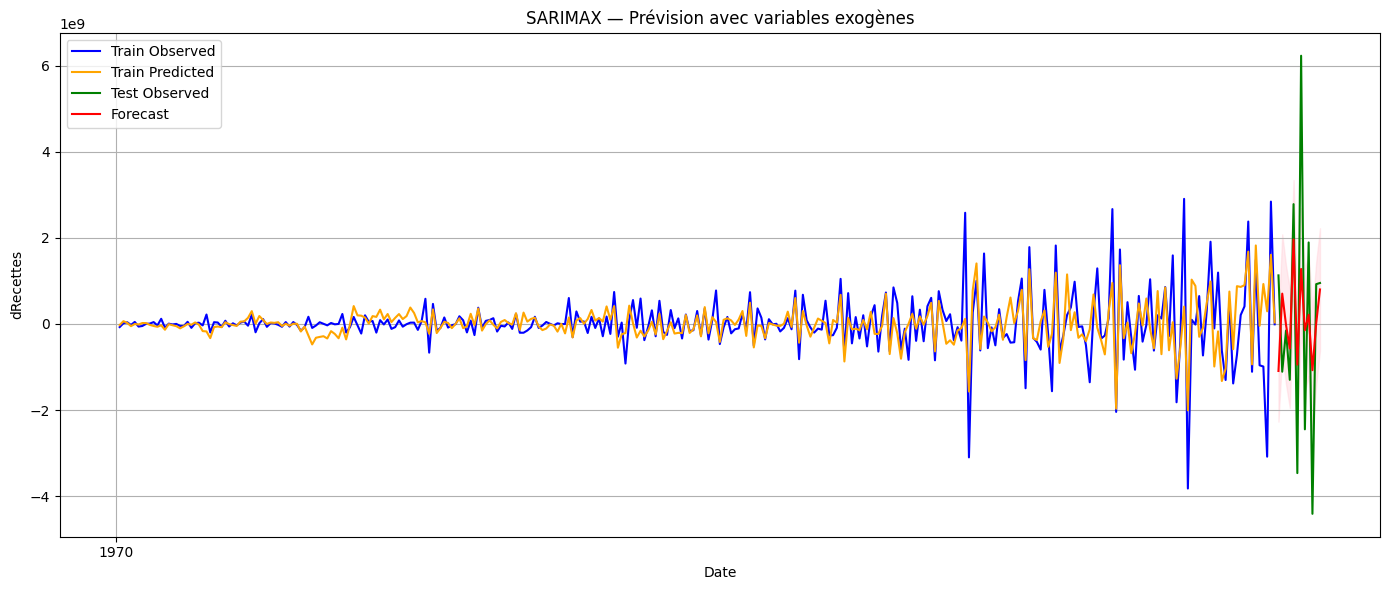

In [53]:
# Prédictions sur l'ensemble de test
forecast = results.get_forecast(steps=12, exog=exog_test)
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

# Prédictions sur l'entraînement
train_pred = results.fittedvalues

# Tracer
plt.figure(figsize=(14,6))
plt.plot(y_train, label='Train Observed', color='blue')
plt.plot(train_pred, label='Train Predicted', color='orange')
plt.plot(y_test, label='Test Observed', color='green')
plt.plot(pred_mean, label='Forecast', color='red')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX — Prévision avec variables exogènes')
plt.xlabel('Date')
plt.ylabel('dRecettes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Statistiques descriptive des variable exogene

In [54]:
print(exog_train.describe())


             dIPC     dChange
count  307.000000  307.000000
mean     0.067759    0.378532
std      1.711508    3.477779
min     -9.000000  -50.501900
25%     -0.600000   -0.006302
50%      0.100000    0.226700
75%      0.700000    0.760806
max      8.500000   12.493300


matrice de correlation entre les variables exogene

In [55]:
print(exog_train.corr())


             dIPC   dChange
dIPC     1.000000  0.185189
dChange  0.185189  1.000000


Que signifie ce résultat ?
La corrélation entre dIPC et dChange est de 0.188, ce qui est :

Faible, mais positive ;

Cela signifie que lorsque l’inflation augmente légèrement, le taux de change a tendance à augmenter aussi, mais pas de manière forte ou systématique.

 Conséquences pour ton modèle
 Bonne nouvelle : une corrélation faible réduit le risque de multicolinéarité, donc tu peux utiliser les deux variables dans un modèle SARIMAX sans problème majeur.

 Si la corrélation avait été proche de 1 ou -1, il aurait fallu envisager :

De retirer une variable,

Ou de faire une combinaison (PCA, ratio, etc.).

In [64]:
df_egxo=pd.read_excel("future_exog.xlsx")
future_exog = df_egxo[['dIPC', 'dChange']]  # 🟢 Très important
df_egxo

,dChange,dIPC
0,0.483793,-0.837361
1,-0.051162,-0.596008
2,0.548034,-0.424221
3,0.178630,-0.301948
4,0.177363,2.747894
5,-0.001958,-2.341738
6,-0.012619,-1.805601
7,0.000409,-1.392212
8,-0.001995,-1.073467
9,0.001886,-0.827698


In [65]:
forecast = results.get_forecast(steps=16, exog=future_exog)

pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()


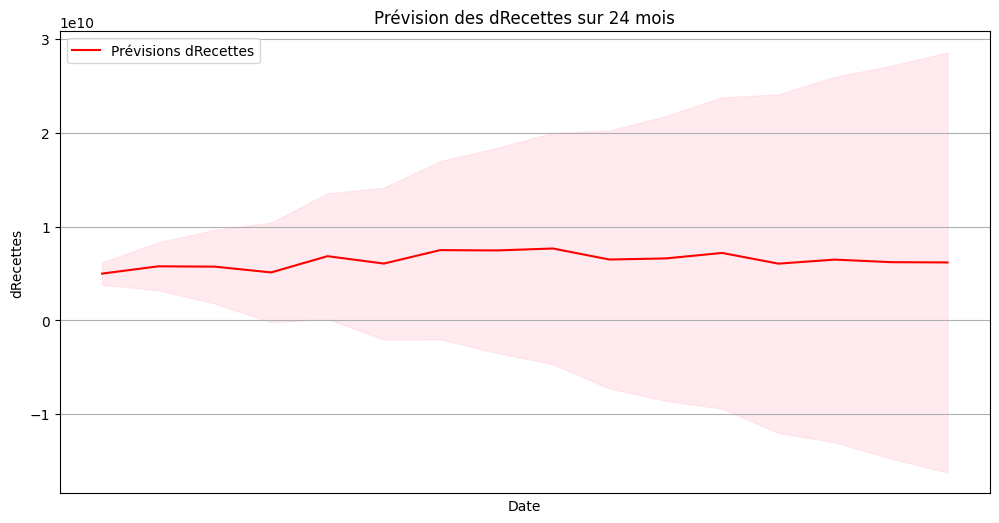

In [66]:
# Dernier niveau connu (à la fin de l'historique)
last_recette = df['Recettes'].iloc[-1]  # Remplace par ton DataFrame avec les niveaux

# Niveau prédit : cumul des différences
forecast_levels = last_recette + pred_mean.cumsum()

# Exemple de plot
plt.figure(figsize=(12,6))
plt.plot(forecast_levels, label='Prévisions dRecettes', color='red')
plt.fill_between(pred_mean.index, 
                 (last_recette + conf_int.iloc[:, 0].cumsum()), 
                 (last_recette + conf_int.iloc[:, 1].cumsum()), 
                 color='pink', alpha=0.3)
plt.title("Prévision des dRecettes sur 24 mois")
plt.xlabel("Date")
plt.ylabel("dRecettes")
plt.legend()
plt.grid(True)
plt.show()


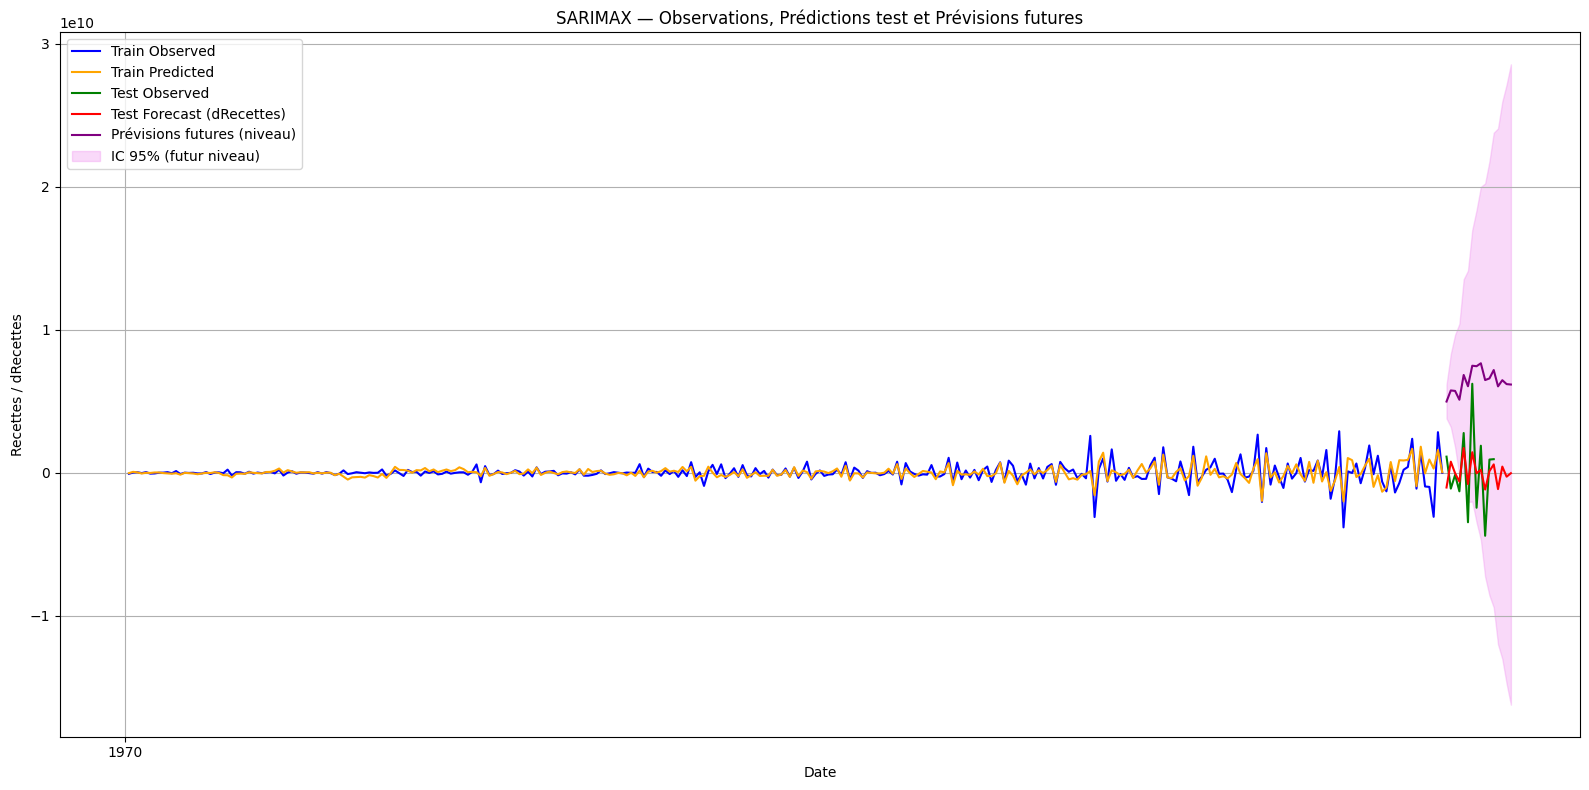

In [67]:
plt.figure(figsize=(16, 8))

# 1. Observations entraînement
plt.plot(y_train.index, y_train, label='Train Observed', color='blue')

# 2. Prédictions entraînement
plt.plot(train_pred.index, train_pred, label='Train Predicted', color='orange')

# 3. Observations test
plt.plot(y_test.index, y_test, label='Test Observed', color='green')

# 4. Prédictions test
plt.plot(pred_mean.index, pred_mean, label='Test Forecast (dRecettes)', color='red')

# 5. Prévisions futures (en niveau, cumulées)
plt.plot(forecast_levels.index, forecast_levels, label='Prévisions futures (niveau)', color='purple')

# 6. Intervalle de confiance cumulé
plt.fill_between(
    forecast_levels.index,
    (last_recette + conf_int.iloc[:, 0].cumsum()),
    (last_recette + conf_int.iloc[:, 1].cumsum()),
    color='violet', alpha=0.3, label='IC 95% (futur niveau)'
)

# 📌 Mise en forme
plt.title("SARIMAX — Observations, Prédictions test et Prévisions futures")
plt.xlabel("Date")
plt.ylabel("Recettes / dRecettes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


je veux combiner plt.plot df['Recette'] et
plt.plot(forecast_levels.index, forecast_levels, label='Prévisions futures (niveau)', color='purple')
pour avoir un graphique qui montre l'evolution des recettes en niveau ainsi que les previsions

### Evolution Recettes VS Prevision

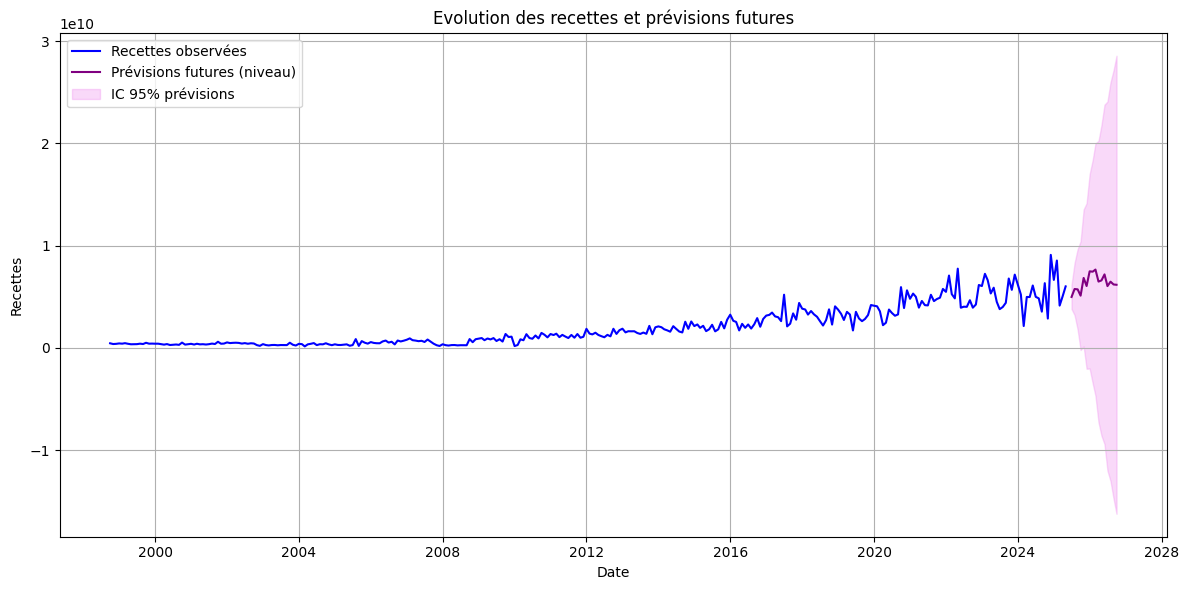

In [79]:
plt.figure(figsize=(12, 6))

# Courbe historique des recettes observées
plt.plot(df['Date'], df['Recettes'], label='Recettes observées', color='blue')

forecast_levels.index = pd.date_range(start=df['Date'].iloc[-1] + pd.DateOffset(months=1), periods=len(forecast_levels), freq='M')

# Prévisions futures (niveau)
plt.plot(forecast_levels.index, forecast_levels, label='Prévisions futures (niveau)', color='purple')

# Intervalle de confiance sur les prévisions futures
plt.fill_between(
    forecast_levels.index,
    (last_recette + conf_int['lower dRecettes'].cumsum()),
    (last_recette + conf_int['upper dRecettes'].cumsum()),
    color='violet', alpha=0.3, label='IC 95% prévisions'
)

plt.title("Evolution des recettes et prévisions futures")
plt.xlabel("Date")
plt.ylabel("Recettes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

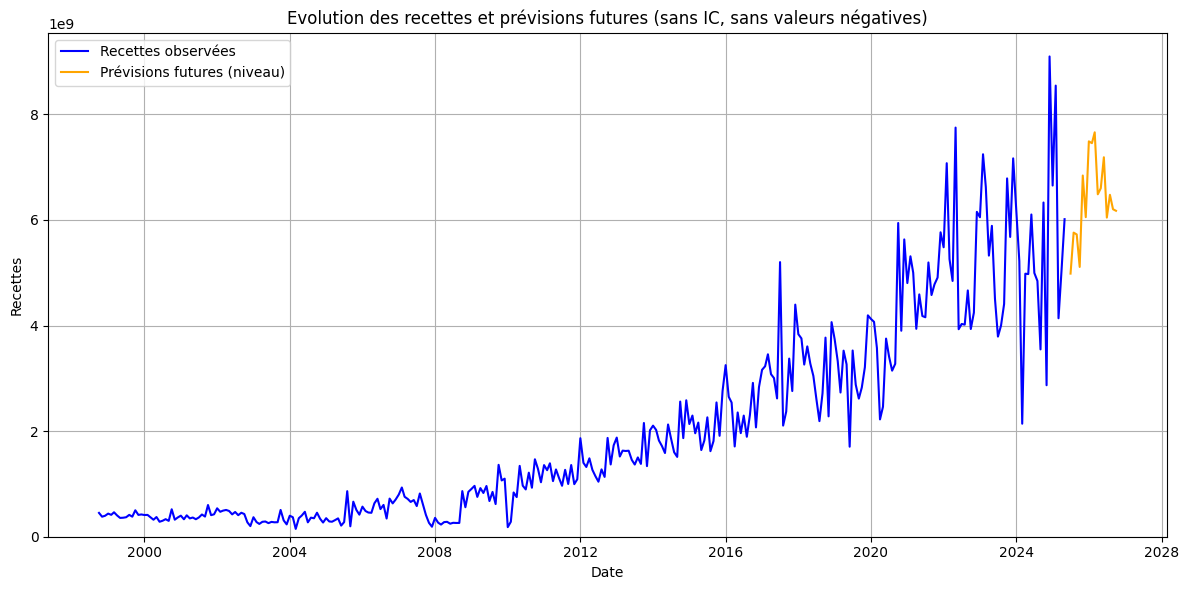

In [80]:
plt.figure(figsize=(12, 6))

# Courbe historique des recettes observées
plt.plot(df['Date'], df['Recettes'], label='Recettes observées', color='blue')

# Prévisions futures (niveau)
plt.plot(forecast_levels.index, forecast_levels, label='Prévisions futures (niveau)', color='orange')

# Limiter l'axe des ordonnées à 0 pour éviter la section négative
plt.ylim(bottom=0)

plt.title("Evolution des recettes et prévisions futures (sans IC, sans valeurs négatives)")
plt.xlabel("Date")
plt.ylabel("Recettes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
# Extraire les prévisions futures des recettes (niveau)
previsions_recettes = forecast_levels.reset_index()
previsions_recettes.columns = ['Date', 'Recettes prévues']
print(previsions_recettes)

         Date  Recettes prévues
0  2025-06-30      4.983245e+09
1  2025-07-31      5.759445e+09
2  2025-08-31      5.725082e+09
3  2025-09-30      5.109600e+09
4  2025-10-31      6.841143e+09
5  2025-11-30      6.052037e+09
6  2025-12-31      7.487916e+09
7  2026-01-31      7.453641e+09
8  2026-02-28      7.659025e+09
9  2026-03-31      6.485403e+09
10 2026-04-30      6.600080e+09
11 2026-05-31      7.186850e+09
12 2026-06-30      6.044195e+09
13 2026-07-31      6.475974e+09
14 2026-08-31      6.202348e+09
15 2026-09-30      6.172983e+09
